# Classifying Names with a Character-Level RNN


This notebook is modified from this [pytorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
authored by [Sean Robertson](https://github.com/spro/practical-pytorch).

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling.

In [ ]:
from __future__ import unicode_literals, print_function, division
%matplotlib inline
my_seed = 0
import numpy as np
np.random.seed(my_seed)
from io import open
import glob
import os
import unicodedata
import string
import random
random.seed(my_seed)
import torch
torch.manual_seed(my_seed)
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json

## Loading the Data

Look at the json files ```training_data.json``` and ```test_data.json```. They contain various names in 18 languages. The languages are the same in the two files, but the names are different.

We load the json files into two dictionaries containing a list of names per language ``{language: [names ...]}``:
- ``train_dict`` contains the data that are going to be used to learn the parameters of the network;
- ``test_dict`` contains data that the network will never see during training, and therefore are they are going to be used for evaluating the performance.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_data.json to test_data (1).json
Saving training_data.json to training_data (1).json


In [ ]:
with open('training_data.json') as json_file:
    train_dict = json.load(json_file)

with open('test_data.json') as json_file:
    test_dict = json.load(json_file)

Let's have a look to the French language.

In [ ]:
# number of training names for the French language
print(len(train_dict['French']))

# number of test names for the French language
print(len(test_dict['French']))

# first 5 training names of the French language
print(train_dict['French'][:5])

221
56
['David', 'Cavey', 'Leroy', 'Pettigrew', 'Parris']


From these dictionaries, we compute some variables that will be needed later on.

In [ ]:
n_train_examples = 0 # number of names for training
n_test_examples = 0 # number of names for test
language_list = [] # list of languages

for language in train_dict.keys():
    language_list.append(language)
    n_train_examples += len(train_dict[language])

for language in test_dict.keys():
    n_test_examples += len(test_dict[language])

n_classes = len(language_list) # number of classes (languages)

all_letters = string.ascii_letters + " .,;'" # all letters 

n_letters = len(all_letters) # number of letters

print(language_list)
print(n_classes)

print(n_train_examples)
print(n_test_examples)

print(n_letters)
print(all_letters)

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
18
16053
4021
57
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of shape
``(1, n_letters)``. A one-hot vector is filled with 0s except 
at the index of the current letter where it is filled with a 1, e.g. ``"b" = [0 1 0 0 0 ...]``.

To make a word we join a bunch of those into a 2D matrix
``(name_length, 1, n_letters)``. ``name_length`` is simply the number of letters 
in the name.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here. For instance, look at the [nn.RNN](https://pytorch.org/docs/stable/nn.html#rnn) layer, it expects an input tensor of shape
``(seq_len, batch, input_size)``, which is precisely what we build.

Recall: The batch size is the number of examples in your training dataset that you
consider to compute the gradient before doing a gradient descent step. 
In stochastic gradient descent (SGD) the batch size is 1, in (standard) gradient descent, 
the batch size is the number of examples in the training set.

In [ ]:
# we'll be working on cpu
device = torch.device("cpu")

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a tensor of shape (1, n_letters)
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor.to(device)

# Turn a name into a tensor of shape (name_length, 1, n_letters),
# or an array of one-hot letter vectors
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor.to(device)


# one hot vector for the letter 'J'
print(letterToTensor('J')) # play with this

# size of the tensor corresponding to the name "Jones" (name_length, 1, n_letters)
print(nameToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# Exercise: Creating the Network

You have to define a **many-to-one** recurrent neural network (RNN) using standard Pytorch layers (and activations) from the ``torch.nn`` module. Use the documentation: https://pytorch.org/docs/stable/nn.html 

Let $\{x_t\}_{t=1}^T$ denote the input sequence, $\{h_t\}_{t=1}^T$ the hidden sequence, and $y$ the output. The forward pass of your network must implement the following steps:

- Initialize hidden state: 

  $$h_0 = 0$$
- For $t=1,...,T$, update hiddent state: 
    
  $$h_t = \sigma_h(W_{xh} x_t + W_{hh} h_{t-1} + b_h)$$
      
- Compute output: 

  $$\hat{y} = \sigma_y( W_{hy} h_T + b_y )$$

where $\sigma_h$ is a ReLU activation function and $\sigma_y$ is a log-softmax activation function (look at the documentation of the ```torch.nn``` module.

In [ ]:
class RNN(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        input_dim: dimension of the input vector x_t
        hidden_dim: dimension of the hidden vector h_t
        output_dim: dimention of the output vector ŷ
        """
        ######## TODO ########

        super(RNN, self).__init__()

        # Option 1
        # self.layer1 = nn.Linear(in_features=input_dim+hidden_dim, out_features=hidden_dim)
        # self.layer2 = nn.Linear(in_features=hidden_dim, out_features=output_dim)
        # self.relu = nn.ReLu()
        # self.lsm = nn.LogSoftmax(dim=1)

        # Option 2
        self.hidden_dim = hidden_dim
        self.fc_x2h = nn.Linear(input_dim, hidden_dim)
        self.fc_h2h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.fc_h2y = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        ######################
        
    def forward(self, x):
        """
        x: sequence of input vectors, shape (seq_len, batch_size, input_dim)
        """
        
        ######## TODO ########
        h = torch.zeros(1, self.hidden_dim, dtype=x.dtype, device=x.device)
        # and with the same tocrch.dtype and torch.device as x

        for t in range(x.size(0)):
          h = self.relu(self.fc_x2h(x[t,:]) + self.fc_h2h(h))

        return self.logsoftmax(self.fc_h2y(h))
        ######################

In [ ]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_classes).to(device)

# print the attributes
print(rnn)

# test the forward
input_tensor = nameToTensor('Albert')
output_tensor = rnn(input_tensor)
print(output_tensor)

RNN(
  (fc_x2h): Linear(in_features=57, out_features=128, bias=True)
  (fc_h2h): Linear(in_features=128, out_features=128, bias=False)
  (fc_h2y): Linear(in_features=128, out_features=18, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax(dim=1)
)
tensor([[-2.9489, -2.8940, -2.8700, -2.8477, -2.7906, -3.0198, -2.8058, -2.8779,
         -2.8827, -2.9264, -2.8241, -2.9734, -2.8589, -2.9115, -2.8623, -2.8995,
         -2.9292, -2.9330]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a tensor of shape ``(1, n_classes)``, where
every item is the likelihood of that category (higher is more likely).




# Training


## Preparing for Training


Before going into training we should make a few helper functions. The
first one interprets the output of the network, which we know corresponds to the
likelihood of each class (language). We can use ``Tensor.topk`` to get the index
of the greatest value.

In [ ]:
def languageFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return language_list[category_i], category_i

print(languageFromOutput(output_tensor))

('English', 4)


We also need a way to randomly pick an example in the training or test set. In supervised learning, an example is a pair (input, label), which for our problem corresponds to a pair (name, language).

In [ ]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomSampling(data_dict):
    language = randomChoice(language_list)
    name = randomChoice(data_dict[language])
    language_tensor = torch.tensor([language_list.index(language)], 
                                    dtype=torch.long)
    name_tensor = nameToTensor(name)
    return language, name, language_tensor.to(device), name_tensor.to(device)

# let's test the helper functions
for i in range(5):
    language, name, language_tensor, name_tensor = randomSampling(train_dict)
    print('language =', language, '/ name =', name)
    print(language_tensor)

language = Polish / name = Gorecki
tensor([12])
language = Portuguese / name = Henriques
tensor([13])
language = Irish / name = O'Neal
tensor([8])
language = Scottish / name = Watson
tensor([15])
language = Italian / name = Tosto
tensor([9])


## Training the Network


As we are solving a multi-class classification problem, we will use the cross-entropy loss. In Pytorch, it corresponds to the negative log-likelihood loss ``nn.NLLLoss``, since the last layer of our RNN is ``nn.LogSoftmax``. Again, look at the documentation: https://pytorch.org/docs/stable/nn.html

In [ ]:
loss_function = nn.NLLLoss()

We are now going to train the network (i.e. optimize the loss function with respect to the network parameters) using **stochastic gradient descent** (SGD). 

We apply the usual recipe, the only difference is that we are now using SGD and not the standard gradient descent. It means that for each epoch, we loop over the training examples, and for each example we do an update of the model parameters. 

We use the above function ```randomSampling``` to randomly pick an example in the training set. Note that using this function, we may pick the same example multiple times within one epoch, which is not optimal. PyTorch has some tools for handling datasets and sampling, but for now, let's forget about this.

Finally, each epoch may take a bit of time (about 30 s on an Intel(R) Core(TM) i7-5820K CPU @ 3.30GHz).

In [ ]:
n_epoch = 12 # number of epochs
learning_rate = 1e-3 # learning rate
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate) # optimize (SGD)
train_loss = [] # to store the training loss after each epoch

for epoch in range(n_epoch):
    
    train_acc_loss = 0 # the accumulated (summed) loss over the training examples
    
    print('Epoch: {}'.format(epoch+1))
    
    for iter in np.arange(n_train_examples):
        
        # We randomly pick an example in the training set.
        # Note that here we may pick the same example multiple times, which is not optimal.
        language, name, language_tensor, name_tensor = randomSampling(train_dict)
        
        rnn.zero_grad() # reset the stored gradients
        
        pred_language_tensor = rnn(name_tensor) # do the forward pass
        
        loss = loss_function(pred_language_tensor, language_tensor) # compute the loss
        
        loss.backward() # do the backward pass -> computes the gradient of the loss
        
        optimizer.step() # do an SGD step
        
        train_acc_loss += loss.item() # accumulate the loss over the training examples
        
    # store the averaged training loss after each epoch
    train_loss.append(train_acc_loss / n_train_examples) 
        
    print('train loss: {:.4f}'.format(train_loss[epoch]))

Epoch: 1
train loss: 1.5377
Epoch: 2
train loss: 0.8895
Epoch: 3
train loss: 0.6855
Epoch: 4
train loss: 0.6181
Epoch: 5
train loss: 0.5554
Epoch: 6
train loss: 0.5474
Epoch: 7
train loss: 0.5236
Epoch: 8
train loss: 0.5174
Epoch: 9
train loss: 0.5024
Epoch: 10
train loss: 0.5025
Epoch: 11
train loss: 0.5256
Epoch: 12
train loss: 0.5008


Text(0.5, 1.0, 'training loss')

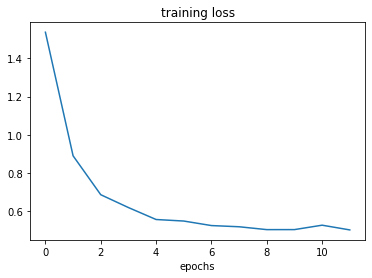

In [ ]:
plt.figure()
plt.plot(train_loss)
plt.xlabel('epochs')
plt.title('training loss')

Note that the loss decreases a lot during the first epoch. However, as we did not compute the loss with the initialized network, we cannot observe this first decrease. Morevoer, in each epoch we perform ``n_training_examples`` updates of the parameters, as we use stochastic gradient descent. We could monitor the loss after each parameter update to see it decrease more gradually. 


Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples from the test set are run through the network.

In [ ]:
confusion = torch.zeros(n_classes, n_classes) # confusion matrix
n_confusion = 1000 # number of examples considered to build the confusion matrix

# Go through a bunch of randomly picked examples in the test set, and store the prediction
for i in range(n_confusion):
    language, name, language_tensor, name_tensor = randomSampling(test_dict)   # if we change for train_dict, the matrix results will be much better (may be overfitting)
    output = rnn(name_tensor)
    guess, guess_i = languageFromOutput(output)
    language_i = language_list.index(language)
    confusion[language_i][guess_i] += 1
    
# Normalize by dividing every row by its sum
for i in range(n_classes):
    confusion[i] = confusion[i] / confusion[i].sum()

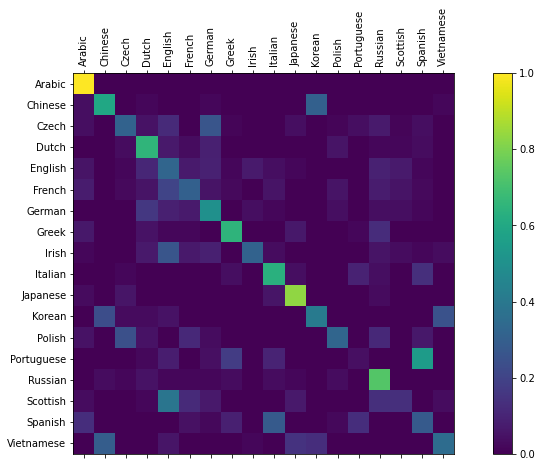

In [ ]:
# Set up plot
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + language_list, rotation=90)
ax.set_yticklabels([''] + language_list)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Bright spots off the main diagonal show which languages the RNN guessed incorrectly. 

Compare the confusion matrices computed from the training and test set. What do you conclude? 


Running on User Input
---------------------




In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = rnn(nameToTensor(input_line))

        # Get top N classes
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            class_index = topi[0][i].item()
            print('(%.2f) %s' % (value, language_list[class_index]))
            predictions.append([value, language_list[class_index]])

predict('Macron')
predict('Merkel')
predict('Johnson')


> Macron
(-0.69) Spanish
(-1.18) French
(-2.24) English

> Merkel
(-0.19) Czech
(-2.81) Russian
(-2.84) Dutch

> Johnson
(-0.57) English
(-1.74) Czech
(-1.84) Polish


In [ ]:
predict('Stulberg')
predict('Huf')
predict('Cavalcanti')


> Stulberg
(-0.56) German
(-1.40) Dutch
(-2.26) Polish

> Huf
(-0.25) Chinese
(-2.36) Korean
(-2.83) Vietnamese

> Cavalcanti
(-0.00) Italian
(-13.22) Spanish
(-13.54) Greek
